In [7]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import shap
import tensorflow
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, roc_curve, auc, precision_score, recall_score, silhouette_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans

RuntimeError: module compiled against API version 0x10 but this version of numpy is 0xf

SystemError: initialization of _pywrap_checkpoint_reader raised unreported exception

## EDA

In [10]:
# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# data (as pandas dataframes) 
df = cdc_diabetes_health_indicators.data.features
df["Diabetes"] = cdc_diabetes_health_indicators.data.targets
X = df.drop(columns='Diabetes')
y = cdc_diabetes_health_indicators.data.targets

# Create df with features and target for graphing purposes later


# Jitter y values for graphing purposes later
y_jitter = []
for i in range(len(y)):
    y_jitter.append(y.loc[i][0] + np.random.uniform(-0.2,0.2))

# feature engineering
genhlth_dict = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}
X['GenHlth'] = X['GenHlth'].map(genhlth_dict)
age_dict = {1: 21, 2: 27, 3: 32, 4: 37, 5: 42, 6: 47, 7: 52, 8: 57, 9: 62, 10: 67, 11: 72, 12: 77, 13: 80}
X['Age'] = X['Age'].map(age_dict)
income_dict = {1: 10, 2: 12.5, 3: 17.5, 4: 22.5, 5: 30, 6: 42.5, 7: 62.5, 8: 75}
X['Income'] = X['Income'].map(income_dict)
X['MentHlth'] = 30 - X['MentHlth']
X['PhysHlth'] = 30 - X['PhysHlth']

/var/folders/dz/gflcnjqn2n5b_9cvt11qn8sr0000gn/T/ipykernel_51215/3364459320.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Diabetes"] = cdc_diabetes_health_indicators.data.targets


In [8]:
# Check for NA
print(X.isna().sum())
print(y.isna().sum())

HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64
Diabetes_binary    0
dtype: int64


In [9]:
# Five Number Summaries of numeric variables
print("BMI Summary: ", np.percentile(X["BMI"], [0, 25, 50, 75, 100]))
print("MentHlth Summary: ", np.percentile(X["MentHlth"], [0, 25, 50, 75, 100]))
print("PhysHlth Summary: ", np.percentile(X["PhysHlth"], [0, 25, 50, 75, 100]))
print("Age Summary: ", np.percentile(X["Age"], [0, 25, 50, 75, 100]))
print("Education Summary: ", np.percentile(X["Education"], [0, 25, 50, 75, 100]))
print("Income Summary: ", np.percentile(X["Income"], [0, 25, 50, 75, 100]))

BMI Summary:  [12. 24. 27. 31. 98.]
MentHlth Summary:  [ 0. 28. 30. 30. 30.]
PhysHlth Summary:  [ 0. 27. 30. 30. 30.]
Age Summary:  [21. 47. 57. 67. 80.]
Education Summary:  [1. 4. 5. 6. 6.]
Income Summary:  [10.  30.  62.5 75.  75. ]


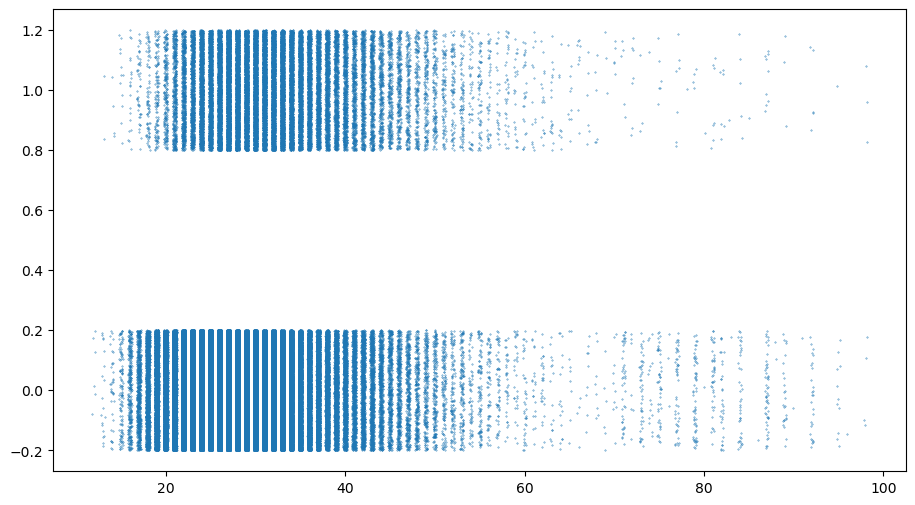

In [5]:
bmi = []
for i in range(len(X["BMI"])):
    bmi.append(X["BMI"][i] + np.random.uniform(-0.2,0.2))
# Diabetes vs. BMI
plt.figure(figsize=(11,6))
plt.scatter(bmi, y_jitter, s=0.1)

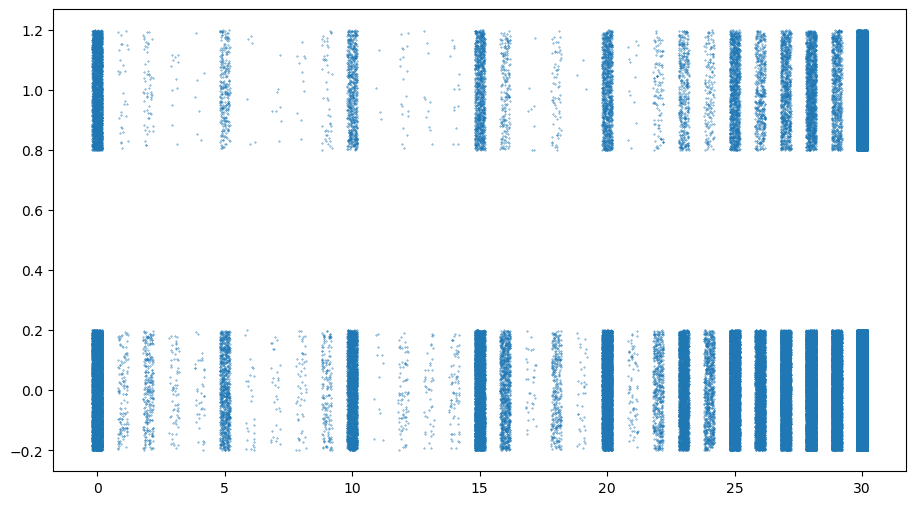

In [6]:
ment = []
for i in range(len(X["MentHlth"])):
    ment.append(X["MentHlth"][i] + np.random.uniform(-0.2,0.2))
plt.figure(figsize=(11,6))
plt.scatter(ment, y_jitter, s = 0.1)

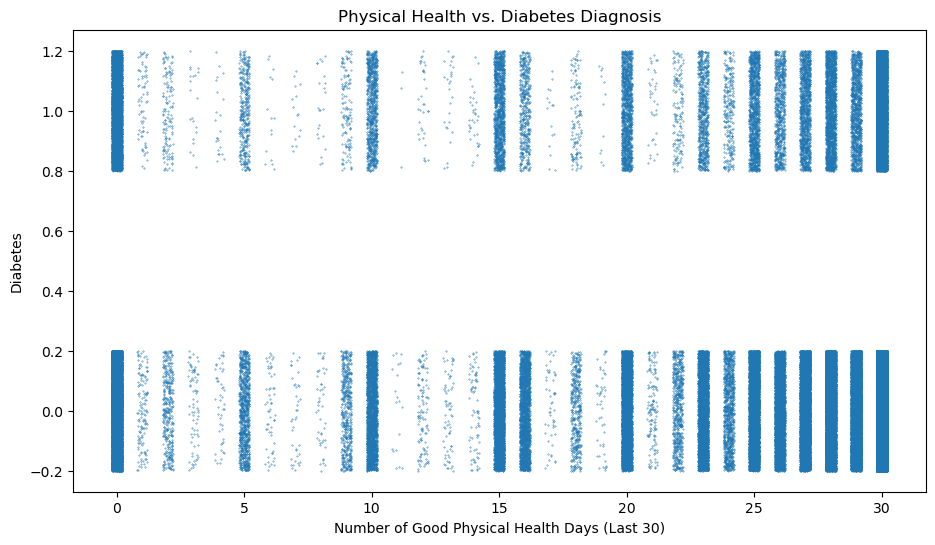

In [7]:
phys = []
for i in range(len(X["PhysHlth"])):
    phys.append(X["PhysHlth"][i] + np.random.uniform(-0.2,0.2))
plt.figure(figsize=(11,6))    
plt.scatter(phys, y_jitter, s = 0.1)
plt.xlabel("Number of Good Physical Health Days (Last 30)")
plt.ylabel("Diabetes")
plt.title("Physical Health vs. Diabetes Diagnosis")
plt.savefig("physhlth")

Text(0.5, 1.0, 'Diabetes by Age')

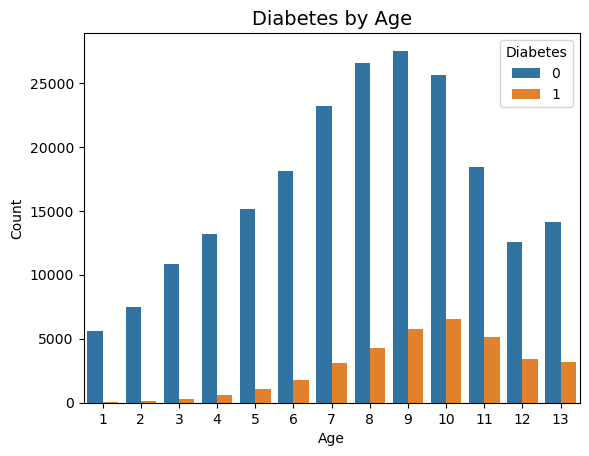

In [8]:
sns.countplot(x="Age", hue="Diabetes", data=df)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Diabetes by Age', fontsize = 14)
#plt.savefig('age')

Text(0.5, 1.0, 'Diabetes by Education Level')

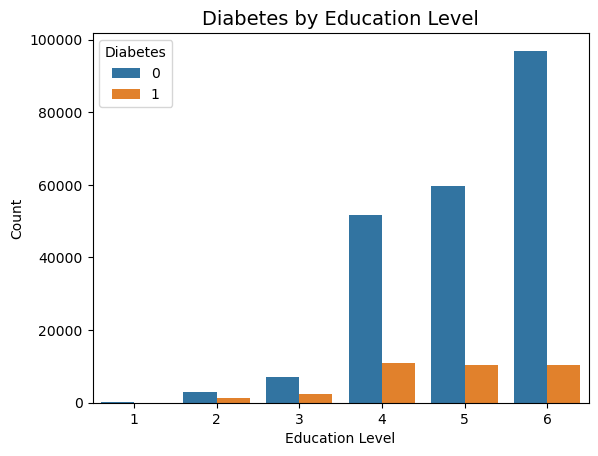

In [9]:
sns.countplot(x="Education", hue="Diabetes", data=df)
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.title('Diabetes by Education Level', fontsize = 14)
#plt.savefig("edu")

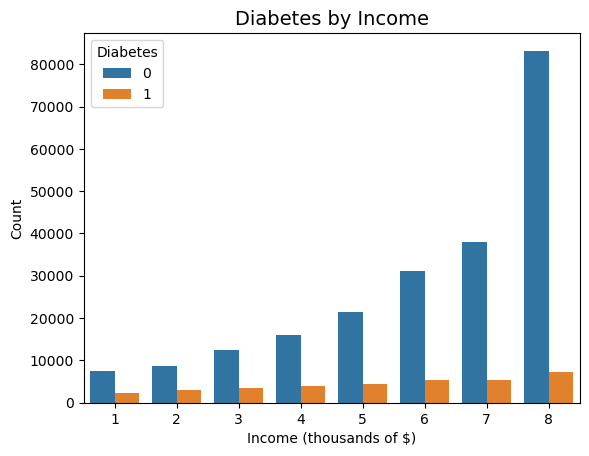

In [10]:
sns.countplot(x="Income", hue="Diabetes", data=df)
plt.xlabel('Income (thousands of $)')
plt.ylabel('Count')
plt.title('Diabetes by Income', fontsize = 14)
plt.savefig('income')

## Model Fitting

In [4]:
# Make train/validation/test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.2)

In [5]:
y_train = np.array(y_train)
y_train = y_train.ravel()
y_test = np.array(y_test)
y_test = y_test.ravel()

In [10]:
log = LogisticRegression(max_iter=1000)
log.fit(X_train, y_train)
train_preds = log.predict(X_train)
test_preds = log.predict(X_test)
y_pred_proba = log.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC: ", auc)
print("Train Accuracy: ", accuracy_score(y_train, train_preds))
print("Test Accuracy: ", accuracy_score(y_test, test_preds))
print("F1 Score: ", f1_score(y_test, test_preds))

AUC:  0.820481262264755
Train Accuracy:  0.8642039183222958
Test Accuracy:  0.8612819299905392
F1 Score:  0.22964098073555164
0.14743499648629654
0.5190499752597724


In [7]:
rf = RandomForestClassifier(min_samples_split=30)
rf.fit(X_train, y_train)
test_preds = rf.predict(X_test)
train_preds = rf.predict(X_train)
y_pred_proba = rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC: ", auc)
print("Train Accuracy: ", accuracy_score(y_train, train_preds))
print("Test Accuracy: ", accuracy_score(y_test, test_preds))
print("F1 Score: ", f1_score(y_test, test_preds))

AUC:  0.8222690792985378
Train Accuracy:  0.8844804478082624
Test Accuracy:  0.8651253547776726
0.20789443222595208


In [15]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
test_preds = gb.predict(X_test)
train_preds = gb.predict(X_train)
y_pred_proba = gb.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC: ", auc)
print("Train Accuracy: ", accuracy_score(y_train, train_preds))
print("Test Accuracy: ", accuracy_score(y_test, test_preds))
print("F1 Score: ", f1_score(y_test, test_preds))

AUC:  0.8280890210593925
Train Accuracy:  0.8673279328287606
Test Accuracy:  0.8646917376222012
0.248823722507933


In [16]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
test_preds = ada.predict(X_test)
train_preds = ada.predict(X_train)
y_pred_proba = ada.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC: ", auc)
print("Train Accuracy: ", accuracy_score(y_train, train_preds))
print("Test Accuracy: ", accuracy_score(y_test, test_preds))
print("F1 Score: ", f1_score(y_test, test_preds))

AUC:  0.8259275211287388
Train Accuracy:  0.8656279564806055
Test Accuracy:  0.8637850835698517
0.2730619543494267


In [17]:
extra = ExtraTreesClassifier(min_samples_split=20)
extra.fit(X_train, y_train)
test_preds = extra.predict(X_test)
train_preds = extra.predict(X_train)
y_pred_proba = extra.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC: ", auc)
print("Train Accuracy: ", accuracy_score(y_train, train_preds))
print("Test Accuracy: ", accuracy_score(y_test, test_preds))
print("F1 Score: ", f1_score(y_test, test_preds))

AUC:  0.8169890014259574
Train Accuracy:  0.8942417612740461
Test Accuracy:  0.8634697256385998
0.17584770969660915


In [18]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
test_preds = knn.predict(X_test)
train_preds = knn.predict(X_train)
print("Train Accuracy: ", accuracy_score(y_train, train_preds))
print("Test Accuracy: ", accuracy_score(y_test, test_preds))
print("F1 Score: ", f1_score(y_test, test_preds))

Train Accuracy:  0.8843129139072847
Test Accuracy:  0.8460067801955219
0.24152994854868465


In [19]:
svc = SVC()
svc.fit(X_train, y_train)
test_preds = svc.predict(X_test)
train_preds = svc.predict(X_train)
print("AUC: ", auc)
print("Train Accuracy: ", accuracy_score(y_train, train_preds))
print("Test Accuracy: ", accuracy_score(y_test, test_preds))
print("F1 Score: ", f1_score(y_test, test_preds))

In [ ]:
gaus = GaussianNB()
gaus.fit(X_train, y_train)
test_preds = gaus.predict(X_test)
train_preds = gaus.predict(X_train)
y_pred_proba = gaus.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC: ", auc)
print("Train Accuracy: ", accuracy_score(y_train, train_preds))
print("Test Accuracy: ", accuracy_score(y_test, test_preds))
print("F1 Score: ", f1_score(y_test, test_preds))

Train Accuracy:  0.7743318353831599
Test Accuracy:  0.7721736045411542
0.4096225547780786


### Hyperparameter Tuning

In [ ]:
pipe = pipe = Pipeline([
    ('grad', GradientBoostingClassifier())
])
params = {
  'grad__loss':('log_loss','exponential'), 
  'grad__learning_rate':(0.05, 0.1, 0.2),
  'grad__n_estimators':(50, 100, 150, 200),
  'grad__criterion':('friedman_mse','squared_error')
}

gs = GridSearchCV(pipe, param_grid=params, scoring='accuracy', cv=10)
gs.fit(X_train, y_train)

In [ ]:
gs.best_params_

{'grad__criterion': 'friedman_mse',
 'grad__learning_rate': 0.2,
 'grad__loss': 'exponential',
 'grad__n_estimators': 200}

In [12]:
gb = GradientBoostingClassifier(criterion="friedman_mse",
                                learning_rate=0.2,
                                loss='exponential',
                                n_estimators=200)
gb.fit(X_train, y_train)
preds = gb.predict(X_test)
y_pred_proba = gb.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC: ", auc)
accuracy_score(y_test, preds)
gb.feature_importances_

AUC:  0.8288164328260146


array([0.270681  , 0.06414654, 0.00638702, 0.16869323, 0.00117   ,
       0.00220872, 0.02098375, 0.00055478, 0.00137008, 0.00094788,
       0.00885223, 0.00080894, 0.00092973, 0.3116364 , 0.00368429,
       0.00345488, 0.03145262, 0.00901923, 0.07563588, 0.00389288,
       0.01348992])

## Final Model

In [11]:
log = LogisticRegression(max_iter=1000)
log.fit(X_train, y_train)
train_preds = log.predict(X_train)
test_preds = log.predict(X_test)
y_pred_proba = log.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print("AUC: ", auc)
print("Train Accuracy: ", accuracy_score(y_train, train_preds))
print("Test Accuracy: ", accuracy_score(y_test, test_preds))
print("F1 Score: ", f1_score(y_test, test_preds))
print(recall_score(y_test, test_preds))
print(precision_score(y_test, test_preds))


AUC:  0.820481262264755
Train Accuracy:  0.8642039183222958
Test Accuracy:  0.8612819299905392
F1 Score:  0.22964098073555164
0.14743499648629654
0.5190499752597724


In [12]:
my_dictionary = {}
coefficients = pd.Series(log.coef_[0])
for key, value in zip(X.columns, coefficients):
    my_dictionary[key] = value
my_dictionary

{'HighBP': 0.7589006037603847,
 'HighChol': 0.5624444610911448,
 'CholCheck': 1.2111873241172098,
 'BMI': 0.061670363862248924,
 'Smoker': -0.01753553406610976,
 'Stroke': 0.1429051061288635,
 'HeartDiseaseorAttack': 0.22192045108398178,
 'PhysActivity': -0.053236538797785934,
 'Fruits': -0.04730424744174797,
 'Veggies': -0.050085309857884217,
 'HvyAlcoholConsump': -0.7948849401259861,
 'AnyHealthcare': 0.07744188680593395,
 'NoDocbcCost': 0.02230499173971441,
 'GenHlth': -0.5395274637406332,
 'MentHlth': 0.003764441801577261,
 'PhysHlth': 0.008001713100990852,
 'DiffWalk': 0.1318795135414125,
 'Sex': 0.2589356980920032,
 'Age': 0.025282648447807834,
 'Education': -0.03188690383246952,
 'Income': -0.004754819228081587}

In [15]:
explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(X_train)
exp = shap.Explanation(shap_values[:,1], explainer.expected_value[1], X_train.toarray(), 
                       feature_names=X.columns)
shap.plots.beeswarm(exp, show=False, color_bar=False)
plt.colorbar()
plt.show()

IndexError: index 1 is out of bounds for axis 0 with size 1

In [14]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=[28,28]))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(300, activation="relu"))
model.add(tf.keras.layers.Dense(100, activation="relu"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

NameError: name 'tf' is not defined